# Analysis of the Yelp Dataset
## Final Project for Data 620

In [1]:
import nltk
import matplotlib as plt
import matplotlib.pyplot as py
% matplotlib inline

In [2]:
import pandas as pd
from pandas.io.json import json_normalize
import io
import json
import seaborn as sns

In [3]:
from numpy import nan
import numpy as np

In [4]:
import networkx as nx
import networkx.algorithms.bipartite as bip

In [5]:
path="C:/Users/talha/Documents/Training/CUNY Classes/IS620/Final_project/yelp_dataset"

### 1. Business Attributes

#### 1.1 Data Cleaning

In [6]:
bus_loc=path+"/business.json"

In [7]:
bus_loc

'C:/Users/talha/Documents/Training/CUNY Classes/IS620/Final_project/yelp_dataset/business.json'

In [8]:
with open(bus_loc, 'rb') as f:
    data = f.readlines()
# remove the trailing "\n" from each line
data = map(lambda x: x.rstrip(), data)

In [9]:
data_json_str="[" + ','.join(data) + "]"

# now, load it into pandas
data_df = pd.read_json(data_json_str)

#### 1.2 Business Data Summary & Study Area Selection 

Initial counts of all business indicate that a significant part of the database is located in Arizona. 

In [13]:
data_df[['state','business_id']].groupby('state').count().sort_values(['business_id'],ascending=False).head(n=5)

,business_id
state,
AZ,56686
NV,36312
ON,33412
NC,14720
OH,14697


From the counts it seems like the number of business in Arizona are significant.
Looking at the US data only - there are other states in the data, but are located outside the US, such as Quebec and Ontario in Canada

In [14]:
data_df[['address','business_id','city','is_open','name','postal_code','review_count','stars','state']].tail(n=3)

,address,business_id,city,is_open,name,postal_code,review_count,stars,state
192606,21230 N 22nd St,MiEyUDKTjeci5TMfxVZPpg,Phoenix,1,Phoenix Pavers,85024,14,4.5,AZ
192607,4406 E Main St,zNMupayB2jEHVDOji8sxoQ,Mesa,1,Beasley's Barber Shop,85205,15,4.5,AZ
192608,3735 S Las Vegas Blvd,c1f_VAX1KIK8-JoVhjbYOw,Las Vegas,0,Oriental Relax,89109,3,4.0,NV


Text(0.5,0,'Business with Number of Reviews')

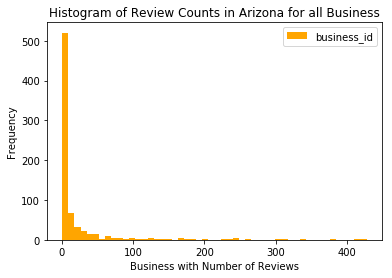

In [39]:
data_df[['business_id','review_count']][(data_df['state']=='AZ')& (data_df['review_count']>25)].groupby(['review_count']).count().plot.hist(bins=50,color='orange',
title='Histogram of Review Counts in Arizona for all Business').set_xlabel('Business with Number of Reviews')

As a comparison we consider the number of "review - counts"; i.e. the number of reviews per business. The number of reviews counts per business are quite comparable with between Arizona and other states - such as Ontario, Canada

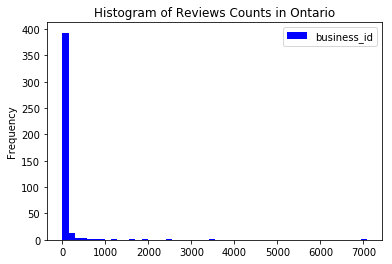

In [40]:
data_df[['business_id','review_count']][data_df['state']=='ON'].groupby(['review_count']).count().plot.hist(bins=50,color='blue',title='Histogram of Reviews Counts in Ontario')

In [41]:
#subset the data for the greater Phoenix area
az_data=data_df[data_df['state']=='AZ']

In [42]:
az_data.tail(n=5)

,address,attributes,business_id,categories,city,hours,is_open,latitude,longitude,name,postal_code,review_count,stars,state
192599,343 N Gilbert Rd,"{u'BusinessAcceptsCreditCards': u'True', u'ByA...",ABjONdA5Fw8XBOM65tmW4w,"Plumbing, Water Heater Installation/Repair, Pr...",Gilbert,"{u'Monday': u'7:0-17:0', u'Tuesday': u'7:0-17:...",1,33.356540,-111.789367,Phend Plumbing & Rooter,85234,47,5.0,AZ
192600,,None,ZidLd2a1uJCMfIhLylX5ww,"Pet Training, Professional Services, Pet Servi...",Phoenix,"{u'Monday': u'8:0-19:30', u'Tuesday': u'8:0-19...",1,33.347160,-111.975380,Team Canine,85076,19,4.5,AZ
192601,5350 E Marriott Dr,"{u'DogsAllowed': u'False', u'BusinessParking':...",jJoPLIhCjkGXy59I4Jl6zw,"Golf, Hotels, Day Spas, Hotels & Travel, Event...",Phoenix,"{u'Monday': u'0:0-0:0', u'Tuesday': u'0:0-0:0'...",1,33.683910,-111.966235,JW Marriott Phoenix Desert Ridge Resort & Spa,85054,441,4.0,AZ
192606,21230 N 22nd St,"{u'BusinessAcceptsCreditCards': u'True', u'ByA...",MiEyUDKTjeci5TMfxVZPpg,"Home Services, Contractors, Landscaping, Mason...",Phoenix,"{u'Friday': u'7:0-15:0', u'Tuesday': u'7:0-15:...",1,33.679992,-112.035569,Phoenix Pavers,85024,14,4.5,AZ
192607,4406 E Main St,"{u'BusinessAcceptsCreditCards': u'False', u'Re...",zNMupayB2jEHVDOji8sxoQ,"Beauty & Spas, Barbers",Mesa,"{u'Tuesday': u'8:30-17:30', u'Friday': u'8:30-...",1,33.416137,-111.735743,Beasley's Barber Shop,85205,15,4.5,AZ


#### 1.3 Business Data Cleaning and Analysis 

In [43]:
#each ouf the businesses have category classifications; 
#these are text lists that need to be processed separately
cats=az_data['categories'].str.split(',',expand=True)

In [44]:
cats.head(n=5)

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,Golf,Active Life,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
3,Insurance,Financial Services,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
8,Nail Salons,Beauty & Spas,Day Spas,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
11,Restaurants,Breakfast & Brunch,Mexican,Tacos,Tex-Mex,Fast Food,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
16,Hair Stylists,Beauty & Spas,Hair Salons,Men's Hair Salons,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None


In [45]:
#there are some 24 categories of classifications; we select the first eight for our purposes
cats=cats.rename(columns={0:'ctg1',1:'ctg2',2:'ctg3',3:'ctg4',4:'ctg5',5:'ctg6',6:'ctg7',7:'ctg8'})

In [46]:
# merge the category data with the data on businesses
az_data=az_data.merge(cats,left_index=True,right_index=True)

In [47]:
#businesses have detailed attributes; these need to be processed further to be used for analysis
bus_att=az_data['attributes'].tolist()

In [58]:
att_detail=pd.DataFrame()
count=[]

In [59]:
for i in range(len(bus_att[0:100])):
    count.append(i)
    if bus_att[i] is None: 
        att_detail=att_detail.append(pd.Series(),ignore_index=True)
    else:
        att_detail=att_detail.append(json_normalize(bus_att[i]),sort='True')

In [60]:
att_detail.head(n=5)

,AcceptsInsurance,AgesAllowed,Alcohol,Ambience,BestNights,BikeParking,BusinessAcceptsBitcoin,BusinessAcceptsCreditCards,BusinessParking,ByAppointmentOnly,...,RestaurantsAttire,RestaurantsDelivery,RestaurantsGoodForGroups,RestaurantsPriceRange2,RestaurantsReservations,RestaurantsTableService,RestaurantsTakeOut,Smoking,WheelchairAccessible,WiFi
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,False,NaN,True,"{'garage': False, 'street': False, 'validated'...",True,...,NaN,NaN,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,u'none',"{'romantic': False, 'intimate': False, 'touris...",NaN,NaN,NaN,True,"{'garage': False, 'street': False, 'validated'...",NaN,...,u'casual',False,True,1,False,NaN,True,NaN,NaN,u'no'
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,"{'garage': False, 'street': False, 'validated'...",True,...,NaN,NaN,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN


In [23]:
att_detail['index']=count

In [24]:
att_detail=att_detail.set_index('index')

In [76]:
az_data['index']=count

In [77]:
az_data=az_data.set_index('index')

In [25]:
#Ambience and the types of meals at the business are lists within lists.
#These also need to be processed further before they can be utilized in a data frame format
#setup empty dataframe containers
amb_det=pd.DataFrame()
meal_det=pd.DataFrame()
amb_count=[]
meal_count=[]

In [26]:
# extract detailed data for 'ambience' and 'Good for meal'
for i in range(len(att_detail)):
    amb_count.append(i)
    if pd.isna(att_detail['Ambience'][i]) or (att_detail['Ambience'][i]=='None'): 
        amb_det=amb_det.append(pd.Series(),ignore_index=True)
    else:
        d = att_detail['Ambience'][i]
        d = d.replace('True', "'True'")
        d = d.replace('False',"'False'")
        d = d.replace("'", "\"")
        d = json.loads(d)
        d=pd.DataFrame.from_dict(d,orient='index')
        d=d.transpose()
        amb_det=amb_det.append(d,sort='True')

In [27]:
amb_det.tail(n=5)

,casual,classy,divey,hipster,intimate,romantic,touristy,trendy,upscale
56681,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
56682,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
56683,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
56684,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
56685,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [44]:
amb_det.shape

(56686, 9)

In [28]:
#update the index
amb_det['index']=amb_count
amb_det=amb_det.set_index('index')

In [29]:
amb_det.tail(n=5)

,casual,classy,divey,hipster,intimate,romantic,touristy,trendy,upscale
index,,,,,,,,,
56681,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
56682,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
56683,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
56684,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
56685,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [30]:
# extract detailed data for 'ambience' and 'Good for meal'
for i in range(len(att_detail)):
    meal_count.append(i)
    if pd.isna(att_detail['GoodForMeal'][i]) or (att_detail['GoodForMeal'][i]=='None'): 
        meal_det=meal_det.append(pd.Series(),ignore_index=True)
    else:
        d = att_detail['GoodForMeal'][i]
        d = d.replace('True', "'True'")
        d = d.replace('False',"'False'")
        d = d.replace("'", "\"")
        d = json.loads(d)
        d=pd.DataFrame.from_dict(d,orient='index')
        d=d.transpose()
        meal_det=meal_det.append(d,sort='True')

In [31]:
meal_det.head(n=10)

,breakfast,brunch,dessert,dinner,latenight,lunch
0,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN,NaN


In [45]:
meal_det.shape

(56686, 6)

In [32]:
#update index 
meal_det['index']=meal_count
meal_det=meal_det.set_index('index')

In [33]:
#merge ambience and meal data
comb_det=amb_det.merge(meal_det,left_index=True,right_index=True)

In [78]:
comb_det.tail(n=5)

,casual,classy,divey,hipster,intimate,romantic,touristy,trendy,upscale,breakfast,brunch,dessert,dinner,latenight,lunch
index,,,,,,,,,,,,,,,
56681,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
56682,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
56683,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
56684,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
56685,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [35]:
#merge combined meal and ambience dataframes with attribute detail
att_detail=att_detail.merge(comb_det,left_index=True,right_index=True)

In [79]:
#vliew all the attributes
att_detail.tail(n=5).transpose()

index,56681,56682,56683,56684,56685
AcceptsInsurance,NaN,NaN,NaN,NaN,NaN
AgesAllowed,NaN,NaN,NaN,NaN,NaN
Alcohol,NaN,NaN,NaN,NaN,NaN
Ambience,NaN,NaN,NaN,NaN,NaN
BYOB,NaN,NaN,NaN,NaN,NaN
BYOBCorkage,NaN,NaN,NaN,NaN,NaN
BestNights,NaN,NaN,NaN,NaN,NaN
BikeParking,NaN,NaN,NaN,NaN,True
BusinessAcceptsBitcoin,NaN,NaN,False,NaN,NaN
BusinessAcceptsCreditCards,True,NaN,True,True,False


In [46]:
att_detail.shape

(56686, 54)

In [56]:
az_data.shape

(56686, 14)

In [80]:
az_data.tail(n=3).transpose()

index,56683,56684,56685
address,5350 E Marriott Dr,21230 N 22nd St,4406 E Main St
attributes,"{u'DogsAllowed': u'False', u'BusinessParking':...","{u'BusinessAcceptsCreditCards': u'True', u'ByA...","{u'BusinessAcceptsCreditCards': u'False', u'Re..."
business_id,jJoPLIhCjkGXy59I4Jl6zw,MiEyUDKTjeci5TMfxVZPpg,zNMupayB2jEHVDOji8sxoQ
categories,"Golf, Hotels, Day Spas, Hotels & Travel, Event...","Home Services, Contractors, Landscaping, Mason...","Beauty & Spas, Barbers"
city,Phoenix,Phoenix,Mesa
hours,"{u'Monday': u'0:0-0:0', u'Tuesday': u'0:0-0:0'...","{u'Friday': u'7:0-15:0', u'Tuesday': u'7:0-15:...","{u'Tuesday': u'8:30-17:30', u'Friday': u'8:30-..."
is_open,1,1,1
latitude,33.6839,33.68,33.4161
longitude,-111.966,-112.036,-111.736
name,JW Marriott Phoenix Desert Ridge Resort & Spa,Phoenix Pavers,Beasley's Barber Shop


In [83]:
#merge the updated attributes data with the full dataframe
az_data=az_data.merge(att_detail,left_index=True,right_index=True)

In [84]:
#quick view of all the data frame detail
az_data.tail(n=3).transpose()

index,56683,56684,56685
address,5350 E Marriott Dr,21230 N 22nd St,4406 E Main St
attributes,"{u'DogsAllowed': u'False', u'BusinessParking':...","{u'BusinessAcceptsCreditCards': u'True', u'ByA...","{u'BusinessAcceptsCreditCards': u'False', u'Re..."
business_id,jJoPLIhCjkGXy59I4Jl6zw,MiEyUDKTjeci5TMfxVZPpg,zNMupayB2jEHVDOji8sxoQ
categories,"Golf, Hotels, Day Spas, Hotels & Travel, Event...","Home Services, Contractors, Landscaping, Mason...","Beauty & Spas, Barbers"
city,Phoenix,Phoenix,Mesa
hours,"{u'Monday': u'0:0-0:0', u'Tuesday': u'0:0-0:0'...","{u'Friday': u'7:0-15:0', u'Tuesday': u'7:0-15:...","{u'Tuesday': u'8:30-17:30', u'Friday': u'8:30-..."
is_open,1,1,1
latitude,33.6839,33.68,33.4161
longitude,-111.966,-112.036,-111.736
name,JW Marriott Phoenix Desert Ridge Resort & Spa,Phoenix Pavers,Beasley's Barber Shop


#### 1.2 Business Data Summary & Study Area Selection 

Summarize the business data by State. In the US most of the business are located in Arizona or Ohio. A large number of businesses are located outside the US

Based on inspection the all the cities in Arizona are part of the larger Phoenix metro area - including cities such as Mesa, Goodyear, Tempe, Scottsdale and others. 
After reviewing the counts, it seems that the larger Phoenix area would have a large enough dataset to be interesting. 

In [60]:
az_data.shape

(56686, 68)

In [86]:
#update the index to have an explicit column for the index
az_data.index.name='index'

In [88]:
index_n=az_data.index

In [91]:
az_data.loc[:,'index_n']=index_n

In [90]:
az_data.head(n=2).transpose()

index,0,1
address,2818 E Camino Acequia Drive,"15655 W Roosevelt St, Ste 237"
business_id,1SWheh84yJXfytovILXOAQ,xvX2CttrVhyG2z1dFg_0xw
city,Phoenix,Goodyear
hours,None,"{u'Friday': u'8:0-17:0', u'Tuesday': u'8:0-17:..."
is_open,0,1
latitude,33.5221,33.4556
longitude,-112.018,-112.396
name,Arizona Biltmore Golf Club,Farmers Insurance - Paul Lorenz
postal_code,85016,85338
review_count,5,3


In [86]:
#drop columns that are not needed
az_data.drop(['attributes','categories',8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24],axis=1,inplace=True)

In [87]:
az_data.shape

(56686, 74)

In [28]:
#read saved/processed data from above
az_data=pd.read_csv(path+'/azdata.csv',low_memory=False)
az_data.shape

(56686, 73)

In [29]:
az_data.head(n=2).transpose()

,0,1
index,0,1
address,2818 E Camino Acequia Drive,"15655 W Roosevelt St, Ste 237"
business_id,1SWheh84yJXfytovILXOAQ,xvX2CttrVhyG2z1dFg_0xw
city,Phoenix,Goodyear
hours,NaN,"{u'Friday': u'8:0-17:0', u'Tuesday': u'8:0-17:..."
is_open,0,1
latitude,33.5221,33.4556
longitude,-112.018,-112.396
name,Arizona Biltmore Golf Club,Farmers Insurance - Paul Lorenz
postal_code,85016,85338


In [30]:
az_data.dtypes[0:35]

index                           int64
address                        object
business_id                    object
city                           object
hours                          object
is_open                         int64
latitude                      float64
longitude                     float64
name                           object
postal_code                   float64
review_count                    int64
stars                         float64
state                          object
ctg1                           object
ctg2                           object
ctg3                           object
ctg4                           object
ctg5                           object
ctg6                           object
ctg7                           object
ctg8                           object
AcceptsInsurance               object
AgesAllowed                    object
Alcohol                        object
Ambience                       object
BYOB                           object
BYOBCorkage 

In [31]:
az_data.dtypes[36:73]

DogsAllowed                  object
DriveThru                    object
GoodForDancing               object
GoodForKids                  object
GoodForMeal                  object
HairSpecializesIn            object
HappyHour                    object
HasTV                        object
Music                        object
NoiseLevel                   object
Open24Hours                  object
OutdoorSeating               object
RestaurantsAttire            object
RestaurantsCounterService    object
RestaurantsDelivery          object
RestaurantsGoodForGroups     object
RestaurantsPriceRange2       object
RestaurantsReservations      object
RestaurantsTableService      object
RestaurantsTakeOut           object
WiFi                         object
casual                       object
classy                       object
divey                        object
hipster                      object
intimate                     object
romantic                     object
touristy                    

#### 1.3 Selection of Businesses related to the Food Industry
The yelp data contains categories of businesses. Varying degrees of detail are provided and the categories are not consistent throughout. For example, category 1 is typically the more detailed, "Burgers", with category 2, listed as "Restaurants". However, this not always the case and there some cases where category 1 is Restaurants and category 2 is "Restaurants".
Below we check and confirm these

In [32]:
# filter out the categories and pick only restaurants
# since there are multiple categories, check and confirm that all have been accurately captures
az_data[['name','address','city','ctg1','ctg2','ctg3','index_n']].set_index('ctg1').filter(like='Restaurants',axis=0).count()

name       3398
address    3373
city       3398
ctg2       3340
ctg3       2094
index_n    3398
dtype: int64

In [33]:
#review counts of businesses by category
az_data[['name','address','city','ctg1','ctg2','ctg3','index_n']].set_index('ctg2').filter(like='Restaurants',axis=0).count()

name       3332
address    3306
city       3332
ctg1       3332
ctg3       1990
index_n    3332
dtype: int64

In [34]:
az_data[['name','address','city','ctg1','ctg2','ctg3','ctg8','index_n']].set_index('ctg8').filter(like='Restaurants',axis=0).count()

name       99
address    96
city       99
ctg1       99
ctg2       99
ctg3       99
index_n    99
dtype: int64

In [35]:
# select a subset of the dataframe that are related to restuarants, filter on eight categories. 
az_data_sel= az_data[(az_data['ctg2'].str.strip()=='Restaurants')|(az_data['ctg3'].str.strip()=='Restaurants')
                     |(az_data['ctg1'].str.strip()=='Restaurants') |(az_data['ctg4'].str.strip()=='Restaurants')
                     |(az_data['ctg5'].str.strip()=='Restaurants')|(az_data['ctg6'].str.strip()=='Restaurants')
                     |(az_data['ctg7'].str.strip()=='Restaurants')|(az_data['ctg8'].str.strip()=='Restaurants')].copy()

In [36]:
az_data_sel.shape

(11340, 73)

In [37]:
az_data.shape

(56686, 73)

#### 1.4 Understanding Restaurant Data

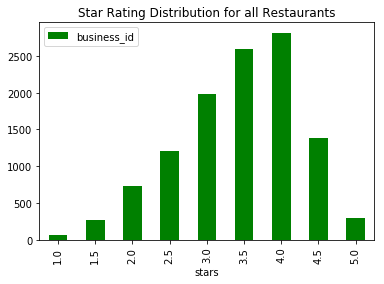

In [38]:
#summarize the star rating of all the businesses
az_data_sel[['business_id','stars']].groupby('stars').count().plot.bar(color='green',title='Star Rating Distribution for all Restaurants')

Text(0.5,0,'Number of Reviews')

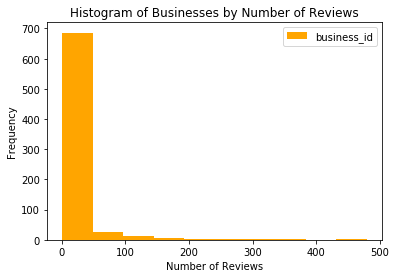

In [39]:
az_data_sel[['business_id','review_count']].groupby('review_count').count().plot.hist(color='orange',title='Histogram of Businesses by Number of Reviews').set_xlabel("Number of Reviews")

In [40]:
grp_cat=az_data_sel[['ctg1','business_id']].groupby('ctg1').count()

In [41]:
grp_cat.sort_values(['business_id'],ascending=False).head(n=20)

,business_id
ctg1,
Restaurants,3398
Mexican,612
Food,569
Fast Food,561
Sandwiches,432
Pizza,400
American (Traditional),354
American (New),298
Nightlife,275


In [42]:
#pull out and examine some specific categories - in this case look at Japanese restaurants 
az_data_sel[['name','ctg1','ctg2','ctg3','ctg4']][az_data_sel['ctg2'].str.strip()=='Japanese'].head(n=5)

,name,ctg1,ctg2,ctg3,ctg4
94,Nishikawa Ramen,Asian Fusion,Japanese,Restaurants,Ramen
477,Ichiban Japanese Restaurant,Restaurants,Japanese,NaN,NaN
726,Kyoto Bowl,Restaurants,Japanese,NaN,NaN
798,Samari Sams,Restaurants,Japanese,NaN,NaN
1638,Little Tokyo,Fast Food,Japanese,Restaurants,NaN


In [43]:
#look at food business with the highest number of reviews
az_data_sel[['city','name','stars','ctg1','ctg2','ctg3','ctg4','ctg5','review_count']].sort_values(['review_count'],ascending=False).head(n=10)

,city,name,stars,ctg1,ctg2,ctg3,ctg4,ctg5,review_count
50312,Phoenix,Bobby Q,4.5,Caterers,Event Planning & Services,Restaurants,American (New),Barbeque,2556
49367,Phoenix,Pizzeria Bianco,4.0,Sandwiches,Restaurants,Pizza,Salad,Tapas/Small Plates,2276
43242,Tempe,Four Peaks Brewing,4.5,Sandwiches,Food,Burgers,Restaurants,American (New),2189
8824,Scottsdale,Rehab Burger Therapy,4.5,Nightlife,Sandwiches,Bars,American (New),Cafes,2071
29349,Phoenix,Lux Central,4.5,Bakeries,American (New),Nightlife,Bars,Coffee & Tea,2046
6080,Gilbert,Joe's Farm Grill,4.0,Pizza,Italian,Restaurants,Salad,Local Flavor,2020
2778,Phoenix,The Arrogant Butcher,4.0,American (New),American (Traditional),Bars,Venues & Event Spaces,Event Planning & Services,1972
39172,Phoenix,La Santisima,4.0,Vegetarian,New Mexican Cuisine,Cafes,Restaurants,Mexican,1967
41922,Phoenix,Cibo,4.5,Restaurants,Italian,Sandwiches,Pizza,NaN,1955
5450,Phoenix,Little Miss BBQ,5.0,Barbeque,Restaurants,NaN,NaN,NaN,1936


In [44]:
#create a dataframe consisting only of high review counts (defined as reviews greater than 20)
az_data_sel_hc=az_data_sel[az_data_sel['review_count']>20].copy()

In [45]:
az_data_sel.shape

(11340, 73)

In [46]:
az_data_sel_hc.shape

(7364, 73)

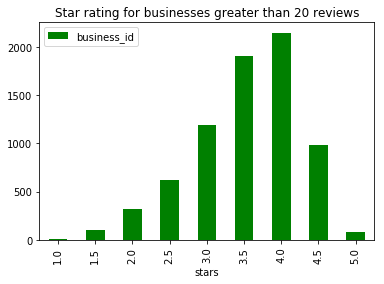

In [47]:
az_data_sel_hc[['business_id','stars']].groupby('stars').count().plot.bar(color='green',title='Star rating for businesses greater than 20 reviews')

In [48]:
#assign review count categories of low, medium and high, and very high
az_data_sel_hc.loc[:,'review_cat']='Low'

In [49]:
az_data_sel_hc.loc[(az_data_sel_hc['review_count']>=250)&(az_data_sel_hc['review_count']<=500),'review_cat']='Med'

In [50]:
az_data_sel_hc.loc[(az_data_sel_hc['review_count']>500)&(az_data_sel_hc['review_count']<=1000),'review_cat']='High'
az_data_sel_hc.loc[(az_data_sel_hc['review_count']>1000),'review_cat']='Very High'

In [58]:
a=az_data_sel_hc[['business_id','stars','review_cat']].groupby(['review_cat','stars']).count().reset_index()

Text(0.5,0.98,'Restaurant Rating by Number of Reviews')

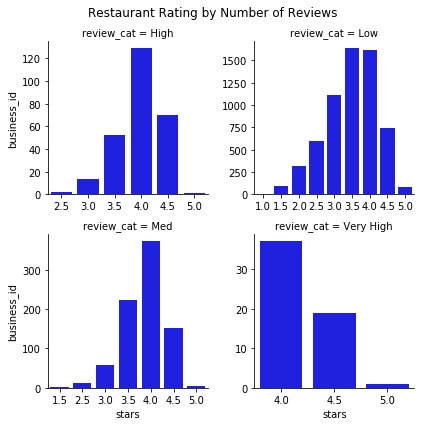

In [59]:
h = sns.FacetGrid(a, col="review_cat", col_wrap=2,sharey=False,sharex=False,row_order=a.review_cat.value_counts().index)
h.map(sns.barplot,'stars','business_id',color='blue')
py.subplots_adjust(top=0.9)
h.fig.suptitle('Restaurant Rating by Number of Reviews')

Text(0.5,0.98,'Histogram of the Number of Reviews by Restaurant Rating')

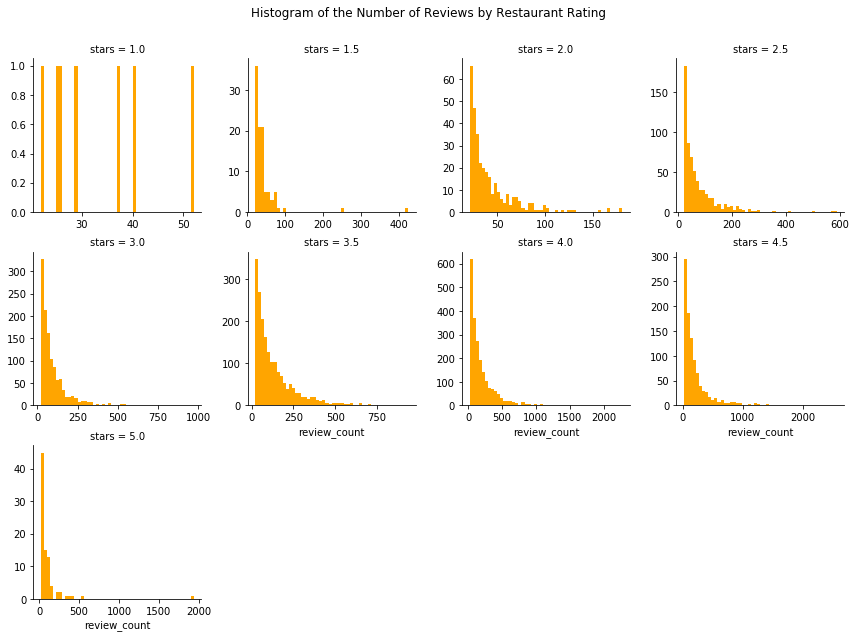

In [53]:
a=az_data_sel_hc[['stars','review_count']].sort_values(['stars','review_count'],ascending=False)
h = sns.FacetGrid(a, col="stars", col_wrap=4,sharey=False,sharex=False)
h.map(py.hist,'review_count',bins=50,color='orange')
py.subplots_adjust(top=0.9)
h.fig.suptitle('Histogram of the Number of Reviews by Restaurant Rating')

In [54]:
#top 10 businesses by food category 1
az_data_sel_hc[['business_id','ctg1']].groupby(['ctg1']).count().sort_values(['business_id'],ascending=False).head(n=10)

,business_id
ctg1,
Restaurants,2046
Mexican,379
Food,356
Fast Food,251
American (Traditional),239
Sandwiches,235
Pizza,235
American (New),215
Nightlife,203


#### 2.0  Reviews

In [6]:
review_loc=path+"/review.json"

In [7]:
review_loc

'C:/Users/talha/Documents/Training/CUNY Classes/IS620/Final_project/yelp_dataset/review.json'

In [8]:
#load all the reviews
reviews = pd.read_json(review_loc,
                       lines=True,
                       chunksize=65000)

In [9]:
# filter & concatenate the chunks
reviews = pd.concat(reviews, ignore_index=True)

In [10]:
reviews.shape

(6685900, 9)

In [11]:
#drop the text of reviews - since for the purposes of this analysis we will not use it
reviews.drop(['text'],axis=1,inplace=True)

In [12]:
reviews.head(n=5)

,business_id,cool,date,funny,review_id,stars,useful,user_id
0,ujmEBvifdJM6h6RLv4wQIg,0,2013-05-07 04:34:36,1,Q1sbwvVQXV2734tPgoKj4Q,1,6,hG7b0MtEbXx5QzbzE6C_VA
1,NZnhc2sEQy3RmzKTZnqtwQ,0,2017-01-14 21:30:33,0,GJXCdrto3ASJOqKeVWPi6Q,5,0,yXQM5uF2jS6es16SJzNHfg
2,WTqjgwHlXbSFevF32_DJVw,0,2016-11-09 20:09:03,0,2TzJjDVDEuAW6MR5Vuc1ug,5,3,n6-Gk65cPZL6Uz8qRm3NYw
3,ikCg8xy5JIg_NGPx-MSIDA,0,2018-01-09 20:56:38,0,yi0R0Ugj_xUx_Nek0-_Qig,5,0,dacAIZ6fTM6mqwW5uxkskg
4,b1b1eb3uo-w561D0ZfCEiQ,0,2018-01-30 23:07:38,0,11a8sVPMUFtaC7_ABRkmtw,1,7,ssoyf2_x0EQMed6fgHeMyQ


In [13]:
reviews.tail(n=5)

,business_id,cool,date,funny,review_id,stars,useful,user_id
6685895,RXBFk3tVBxiTf3uOt9KExQ,0,2018-07-03 12:17:27,0,0pCaq1hqAViS2N6ldlp_sQ,5,1,Xu_YazIajfsc7SRj1wJ6Mg
6685896,yA6dKNm_zl1ucZCnwW8ZCg,5,2013-05-22 15:32:08,11,jPCXuSBbI_cPocgoNBhdkg,1,13,V6BjjQICDO4q7TT3ZhaPWw
6685897,a192hdM0_UVCYLwPJv1Qwg,0,2018-11-13 21:15:20,0,zwzO3yPdGbdgGy3-XQ0SWg,5,0,PFiIECX8wuvi7P-1mCvIjA
6685898,kOo4ZY2UQAX4j312mzQ8mA,1,2018-08-13 18:09:16,1,o8Nc2BJhKJXM6tRHJDRuPA,5,1,wu5R5_N7q5iqCBh6NBX26Q
6685899,PkqN5st3zZ_Xce_5QlBtNQ,0,2018-11-12 20:25:32,0,OKmOLFwtI-NjofTHAGzv1Q,3,2,Ej3mCvjcwVXCSPB_avIfjQ


In [14]:
users=reviews[['user_id','review_id']].groupby(['user_id']).count().sort_values(['review_id'],ascending=False)

In [15]:
users.shape

(1637138, 1)

In [16]:
user_num=np.arange(0,1637138)

In [17]:
users['user_num']=user_num

In [18]:
users.head(n=5)

,review_id,user_num
user_id,,
CxDOIDnH8gp9KXzpBHJYXw,4129,0
bLbSNkLggFnqwNNzzq-Ijw,2354,1
PKEzKWv_FktMm2mGPjwd0Q,1822,2
ELcQDlf69kb-ihJfxZyL0A,1764,3
DK57YibC5ShBmqQl97CKog,1727,4


In [19]:
users=users.rename(columns={'review_id':'review_count'})

In [20]:
users.head(n=5)

,review_count,user_num
user_id,,
CxDOIDnH8gp9KXzpBHJYXw,4129,0
bLbSNkLggFnqwNNzzq-Ijw,2354,1
PKEzKWv_FktMm2mGPjwd0Q,1822,2
ELcQDlf69kb-ihJfxZyL0A,1764,3
DK57YibC5ShBmqQl97CKog,1727,4


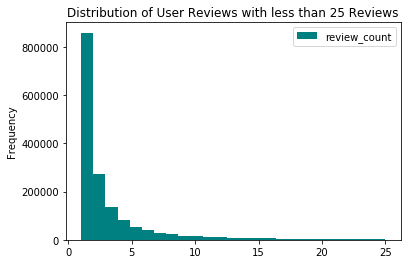

In [100]:
##Number of users with 25 reviews or less
users[(users['review_count']<=25)][['review_count']].plot.hist(bins=25,color='teal',title='Distribution of User Reviews with less than 25 Reviews')

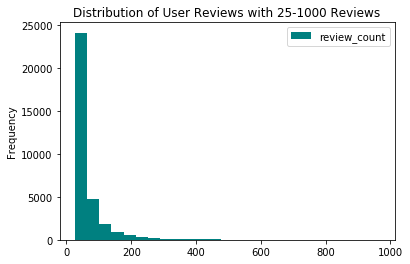

In [101]:
##Number of users with 100 to 1000 reviews
users[(users['review_count']>25) & (users['review_count']<1000)][['review_count']].plot.hist(bins=25,color='teal',title='Distribution of User Reviews with 25-1000 Reviews')

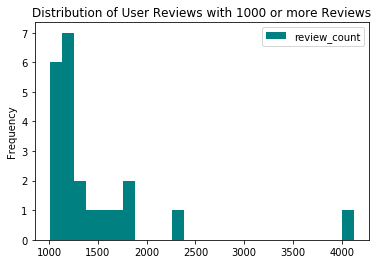

In [102]:
##Number of users with greater than 1000 reviews
users[(users['review_count']>=1000)][['review_count']].plot.hist(bins=25,color='teal',title='Distribution of User Reviews with 1000 or more Reviews')

In [24]:
reviews=reviews.merge(users,left_on='user_id',right_on='user_id')

In [25]:
reviews.tail(n=5)

,business_id,cool,date,funny,review_id,stars,useful,user_id,review_count,user_num
6685895,6-VJLO3Phc8uenJaLH54Og,0,2018-11-05 20:10:48,0,neGltnnTvLQLDxYZRIxJmA,5,0,6rbBCrndAPCmgzDbB1vDxQ,1,821668
6685896,T-eEjmbEeQ53ezioW_9vxQ,0,2015-04-07 17:57:29,9,NLhVwKW2uNgK4GZrDiaQug,1,6,73102fWuyLRHVWLK6_UqrQ,1,811115
6685897,BwuyBsShSQwO3_-SvW6fRA,0,2018-11-07 23:27:41,0,PdvJkMZBmFSBXFkUJWSdZg,5,0,GRlpSOrhsBYbjqNoaemopw,1,1618540
6685898,3kdSl5mo9dWC4clrQjEDGg,0,2018-11-11 19:11:03,0,yZbleOxC4_k8n4FclEBIRw,5,0,pSvD8Djf3g8eR9VmgaRKhA,1,825946
6685899,a192hdM0_UVCYLwPJv1Qwg,0,2018-11-13 21:15:20,0,zwzO3yPdGbdgGy3-XQ0SWg,5,0,PFiIECX8wuvi7P-1mCvIjA,1,1332666


In [26]:
reviews.head(n=5)

,business_id,cool,date,funny,review_id,stars,useful,user_id,review_count,user_num
0,ujmEBvifdJM6h6RLv4wQIg,0,2013-05-07 04:34:36,1,Q1sbwvVQXV2734tPgoKj4Q,1,6,hG7b0MtEbXx5QzbzE6C_VA,10,121621
1,xpEq8x5caXFm2lmjQ51rVQ,0,2014-02-27 04:20:15,0,D4_FpPSPRNtAj1964vXFPQ,2,2,hG7b0MtEbXx5QzbzE6C_VA,10,121621
2,ujmEBvifdJM6h6RLv4wQIg,0,2013-03-27 14:17:13,0,oy8f3bxyl7zZJFDQ5edtIA,1,3,hG7b0MtEbXx5QzbzE6C_VA,10,121621
3,lsAe6PMRTVGtaBqw3zKlMQ,0,2013-04-24 09:04:10,0,nsr-0uYDWv22qFdARRa2CQ,2,0,hG7b0MtEbXx5QzbzE6C_VA,10,121621
4,Y07qIurPKiUJDnTZWxZN2A,0,2012-08-28 23:34:11,0,HeTRGukwBk1TPoX0dr4xZA,5,0,hG7b0MtEbXx5QzbzE6C_VA,10,121621


#### 3.0 Setup Network Analysis

##### 3.1 Develop Regional cuisine categorization

In [60]:
az_data_sel_hc.columns

Index([u'index', u'address', u'business_id', u'city', u'hours', u'is_open',
       u'latitude', u'longitude', u'name', u'postal_code', u'review_count',
       u'stars', u'state', u'ctg1', u'ctg2', u'ctg3', u'ctg4', u'ctg5',
       u'ctg6', u'ctg7', u'ctg8', u'AcceptsInsurance', u'AgesAllowed',
       u'Alcohol', u'Ambience', u'BYOB', u'BYOBCorkage', u'BestNights',
       u'BikeParking', u'BusinessAcceptsBitcoin',
       u'BusinessAcceptsCreditCards', u'ByAppointmentOnly', u'Caters',
       u'CoatCheck', u'Corkage', u'DietaryRestrictions', u'DogsAllowed',
       u'DriveThru', u'GoodForDancing', u'GoodForKids', u'GoodForMeal',
       u'HairSpecializesIn', u'HappyHour', u'HasTV', u'Music', u'NoiseLevel',
       u'Open24Hours', u'OutdoorSeating', u'RestaurantsAttire',
       u'RestaurantsCounterService', u'RestaurantsDelivery',
       u'RestaurantsGoodForGroups', u'RestaurantsPriceRange2',
       u'RestaurantsReservations', u'RestaurantsTableService',
       u'RestaurantsTakeOut', u'WiFi',

In [75]:
#select specific columns for further analysis
select_hc=az_data_sel_hc[['name','index_n','address','business_id','city','is_open','latitude','longitude',
                          'postal_code','review_count','stars','ctg1','ctg2','ctg3','ctg4','ctg5','ctg6','ctg7',
                          'ctg8','review_cat']].copy()

In [76]:
select_hc.head(n=5)

,name,index_n,address,business_id,city,is_open,latitude,longitude,postal_code,review_count,stars,ctg1,ctg2,ctg3,ctg4,ctg5,ctg6,ctg7,ctg8,review_cat
21,Nee House Chinese Restaurant,21,"13843 N Tatum Blvd, Ste 15",44YFU284Z3KDEy25QyVoUw,Phoenix,1,33.613020,-111.977036,85032.0,269,3.5,Chinese,Restaurants,NaN,NaN,NaN,NaN,NaN,NaN,Med
37,Vintage 95,37,95 W Boston,r8764MtYyt8JhxMvrfM_xQ,Chandler,0,33.302093,-111.842613,85225.0,320,4.0,American (New),Bars,Wine Bars,Nightlife,Restaurants,NaN,NaN,NaN,Med
40,New Mexican Grill,40,"3140 S Gilbert Rd, Ste 3",voZnDQs6Hs3YpNcS-9TALg,Chandler,0,33.261325,-111.790815,85286.0,84,4.0,Restaurants,Mexican,NaN,NaN,NaN,NaN,NaN,NaN,Low
43,Salt Cellar,43,550 N Hayden Rd,nsNONDHbV7Vudqh21uicqw,Scottsdale,1,33.454286,-111.909405,85257.0,526,3.5,Seafood,Restaurants,NaN,NaN,NaN,NaN,NaN,NaN,High
51,Yummy Yummy Chinese Restaurant,51,"2765 N Scottsdale Rd, Ste 105",MhnihE0alud0ereVInSt8Q,Scottsdale,1,33.478754,-111.925484,85257.0,188,3.0,Chinese,Restaurants,NaN,NaN,NaN,NaN,NaN,NaN,Low


In [63]:
#setup a list of categories
categ_list=[]

In [64]:
field_list=['ctg1','ctg2','ctg3','ctg4','ctg5','ctg6','ctg7','ctg8']

In [65]:
for f in field_list:
    for c in set(select_hc[f].str.strip()):
        if c not in categ_list:
            categ_list.append(c)

In [66]:
len(categ_list)

365

In [69]:
sorted(categ_list)

[nan,
 'Acai Bowls',
 'Accessories',
 'Active Life',
 'Afghan',
 'African',
 'Airports',
 'Amateur Sports Teams',
 'American (New)',
 'American (Traditional)',
 'Amusement Parks',
 'Animal Shelters',
 'Antiques',
 'Appliances',
 'Appliances & Repair',
 'Arabian',
 'Arcades',
 'Archery',
 'Argentine',
 'Armenian',
 'Art Classes',
 'Art Galleries',
 'Art Schools',
 'Arts & Crafts',
 'Arts & Entertainment',
 'Asian Fusion',
 'Australian',
 'Austrian',
 'Auto Customization',
 'Auto Detailing',
 'Auto Upholstery',
 'Automotive',
 'Bagels',
 'Bakeries',
 'Bar Crawl',
 'Barbeque',
 'Barbers',
 'Bars',
 'Bartenders',
 'Basque',
 'Beauty & Spas',
 'Bed & Breakfast',
 'Beer',
 'Beer Bar',
 'Beer Garden',
 'Beer Gardens',
 'Belgian',
 'Beverage Store',
 'Bistros',
 'Books',
 'Bookstores',
 'Bowling',
 'Brazilian',
 'Breakfast & Brunch',
 'Breweries',
 'Brewpubs',
 'British',
 'Bubble Tea',
 'Buffets',
 'Building Supplies',
 'Burgers',
 'Burmese',
 'Butcher',
 'Cafes',
 'Cafeteria',
 'Cajun/Creole

In [103]:
# visually inspect the above list to develop regional cuisine list and food types list 
region_list=['British','Colombian','Persian/Iranian','Polish','French','Filipino','Italian','Mediterranean','Morroccan','Puerto Rican','Cantonese','Austrian','Turkish',
            'Tex-Mex','American (New)','Pan Asian','Hawaiian','Szechuan','Thai','Cuban','Cajun/Creole','Greek','Burmese','African','Chinese','Asian Fusion','Middle Eastern',
             'Indian','Pakistani','Brazilian','Carribbean','Korean','Afghan','Malaysian','Modern European','Irish','German','Taiwanese','American (Traditional)','Latin American',
             'Laotian','Mongolian','Vietnamese','Lebanese','Mexican','Peruvian','Japanese','Spanish','Salvadoran','Armenian','Uzbek','Scandinavian','Czech','Trinidadian','Indonesian',
            'Singaporean','Ethiopian','Hungarian','Russian','Australian','Cambodian','Belgian','Shanghainese','Ukranian','Dominican','Seafood','Fast Food']

In [104]:
sorted(region_list)

['Afghan',
 'African',
 'American (New)',
 'American (Traditional)',
 'Armenian',
 'Asian Fusion',
 'Australian',
 'Austrian',
 'Belgian',
 'Brazilian',
 'British',
 'Burmese',
 'Cajun/Creole',
 'Cambodian',
 'Cantonese',
 'Carribbean',
 'Chinese',
 'Colombian',
 'Cuban',
 'Czech',
 'Dominican',
 'Ethiopian',
 'Fast Food',
 'Filipino',
 'French',
 'German',
 'Greek',
 'Hawaiian',
 'Hungarian',
 'Indian',
 'Indonesian',
 'Irish',
 'Italian',
 'Japanese',
 'Korean',
 'Laotian',
 'Latin American',
 'Lebanese',
 'Malaysian',
 'Mediterranean',
 'Mexican',
 'Middle Eastern',
 'Modern European',
 'Mongolian',
 'Morroccan',
 'Pakistani',
 'Pan Asian',
 'Persian/Iranian',
 'Peruvian',
 'Polish',
 'Puerto Rican',
 'Russian',
 'Salvadoran',
 'Scandinavian',
 'Seafood',
 'Shanghainese',
 'Singaporean',
 'Spanish',
 'Szechuan',
 'Taiwanese',
 'Tex-Mex',
 'Thai',
 'Trinidadian',
 'Turkish',
 'Ukranian',
 'Uzbek',
 'Vietnamese']

In [105]:
len(region_list)

67

In [106]:
select_hc['region_cat']=np.nan

In [118]:
select_hc[['name','city','ctg1','ctg2','ctg3','ctg4','ctg5','ctg6','review_cat']].head(n=5)

,name,city,ctg1,ctg2,ctg3,ctg4,ctg5,ctg6,review_cat
21,Nee House Chinese Restaurant,Phoenix,Chinese,Restaurants,NaN,NaN,NaN,NaN,Med
37,Vintage 95,Chandler,American (New),Bars,Wine Bars,Nightlife,Restaurants,NaN,Med
40,New Mexican Grill,Chandler,Restaurants,Mexican,NaN,NaN,NaN,NaN,Low
43,Salt Cellar,Scottsdale,Seafood,Restaurants,NaN,NaN,NaN,NaN,High
51,Yummy Yummy Chinese Restaurant,Scottsdale,Chinese,Restaurants,NaN,NaN,NaN,NaN,Low


In [108]:
for item in region_list:
    select_hc['region_cat'][(select_hc['ctg2'].str.strip()==item)|(select_hc['ctg3'].str.strip()==item)
                     |(select_hc['ctg1'].str.strip()==item) |(select_hc['ctg4'].str.strip()==item)
                     |(select_hc['ctg5'].str.strip()==item)|(select_hc['ctg6'].str.strip()==item)
                     |(select_hc['ctg7'].str.strip()==item)|(select_hc['ctg8'].str.strip()==item)]=item

C:\Users\talha\AppData\Local\conda\conda\envs\heckman\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [119]:
select_hc[['name','city','ctg1','ctg2','ctg3','ctg4','ctg5','ctg6','review_cat','region_cat']].head(n=5)

,name,city,ctg1,ctg2,ctg3,ctg4,ctg5,ctg6,review_cat,region_cat
21,Nee House Chinese Restaurant,Phoenix,Chinese,Restaurants,NaN,NaN,NaN,NaN,Med,Chinese
37,Vintage 95,Chandler,American (New),Bars,Wine Bars,Nightlife,Restaurants,NaN,Med,American (New)
40,New Mexican Grill,Chandler,Restaurants,Mexican,NaN,NaN,NaN,NaN,Low,Mexican
43,Salt Cellar,Scottsdale,Seafood,Restaurants,NaN,NaN,NaN,NaN,High,Seafood
51,Yummy Yummy Chinese Restaurant,Scottsdale,Chinese,Restaurants,NaN,NaN,NaN,NaN,Low,Chinese


In [110]:
select_hc[['business_id','region_cat']].groupby(['region_cat']).count().sort_values(['business_id'],ascending=False)

,business_id
region_cat,
Fast Food,981
American (Traditional),980
Mexican,850
American (New),530
Italian,521
Seafood,356
Chinese,255
Japanese,248
Vietnamese,116


##### 3.2 Merge Business Ratings and Reviews 

In [111]:
#merge the business dataframe with the reviews dataframe
final=select_hc.merge(reviews,left_on='business_id',right_on='business_id')

In [112]:
final.shape

(1127750, 30)

In [113]:
final=final.rename(columns={'review_count_x':'bus_reviews','stars_x':'bus_stars','stars_y':'usr_stars','review_count_y':'usr_reviews'})

In [114]:
final=final[(final['is_open']!=0)|(final['region_cat']!=np.nan)]

In [115]:
#remove closed and no region category from the list
final.shape

(1127750, 30)

In [120]:
select_hc.shape

(7364, 21)

#### 4.0 Conducting the Social Network Analysis

In [124]:
final.head()

,name,index_n,address,business_id,city,is_open,latitude,longitude,postal_code,bus_reviews,...,region_cat,cool,date,funny,review_id,usr_stars,useful,user_id,usr_reviews,user_num
0,Nee House Chinese Restaurant,21,"13843 N Tatum Blvd, Ste 15",44YFU284Z3KDEy25QyVoUw,Phoenix,1,33.61302,-111.977036,85032.0,269,...,Chinese,3,2017-09-21 05:18:18,2,gGGbacCwLc095y-CZ5qzOA,3,4,Olo_x4fV1sFBtlj6COf9Wg,251,782
1,Nee House Chinese Restaurant,21,"13843 N Tatum Blvd, Ste 15",44YFU284Z3KDEy25QyVoUw,Phoenix,1,33.61302,-111.977036,85032.0,269,...,Chinese,1,2012-04-28 21:08:22,0,QgV9RPyPUC3cAse1Wxqoow,4,2,P3cMpkppvBuVpPD8LBTbBQ,13,81489
2,Nee House Chinese Restaurant,21,"13843 N Tatum Blvd, Ste 15",44YFU284Z3KDEy25QyVoUw,Phoenix,1,33.61302,-111.977036,85032.0,269,...,Chinese,0,2017-02-09 05:15:25,0,1ZTO6zFtVVxtXclHp4TvHQ,3,0,b1yLsCdv4ZL_d3INMCZzoA,5,284598
3,Nee House Chinese Restaurant,21,"13843 N Tatum Blvd, Ste 15",44YFU284Z3KDEy25QyVoUw,Phoenix,1,33.61302,-111.977036,85032.0,269,...,Chinese,1,2011-06-23 17:25:11,1,iMwFrZI_TX7wIb3vWTcdZA,3,2,TXSqa_4aKgc-s0QbaoaLzw,58,10507
4,Nee House Chinese Restaurant,21,"13843 N Tatum Blvd, Ste 15",44YFU284Z3KDEy25QyVoUw,Phoenix,1,33.61302,-111.977036,85032.0,269,...,Chinese,1,2016-08-12 21:38:55,3,h17ep5S7O8_JMKovooWoVA,5,0,TaVuQWmXAhxy_LvIXBs9sg,169,1735


In [164]:
#select the first 5000 rows for initial analysis 
a=final.iloc[0:5000,:]

In [165]:
#see all the data items
a.dtypes

name                   object
index_n                 int64
address                object
business_id            object
city                   object
is_open                 int64
latitude              float64
longitude             float64
postal_code           float64
bus_reviews             int64
bus_stars             float64
ctg1                   object
ctg2                   object
ctg3                   object
ctg4                   object
ctg5                   object
ctg6                   object
ctg7                   object
ctg8                   object
review_cat             object
region_cat             object
cool                    int64
date           datetime64[ns]
funny                   int64
review_id              object
usr_stars               int64
useful                  int64
user_id                object
usr_reviews             int64
user_num                int32
dtype: object

In [166]:
#all the restuarant names included in the sample
set(a['name'])

{'Anise Vietnamese Restaurant',
 'Baskin-Robbins',
 'Bay Leaf Cafe',
 'Birrieria Obregon',
 'Cave Creek Tap Haus',
 'Eggstasy',
 'Five Guys',
 'Heart Attack Grill',
 'La Flor De Calabaza',
 "Mimi's Cafe",
 'Naya Mediterranean Cuisine',
 'Nee House Chinese Restaurant',
 'New Mexican Grill',
 'Nishikawa Ramen',
 'Noodles Ranch',
 "Oregano's Pizza Bistro",
 'PHO KC',
 'Panera Bread',
 "Piggly's At the Fair",
 'Sakana Sushi & Grill',
 'Salt Cellar',
 'Vintage 95',
 'Yao Fine Chinese Cuisine',
 'Yummy Yummy Chinese Restaurant'}

In [168]:
a['user_num'][0:10]

0       782
1     81489
2    284598
3     10507
4      1735
5       859
6       616
7       616
8      4716
9      4716
Name: user_num, dtype: int32

In [169]:
len(set(a['user_num']))

4555

In [123]:
a[['region_cat']][(a['name']=='Five Guys')].head(n=5)

,region_cat
2131,Fast Food
2132,Fast Food
2133,Fast Food
2134,Fast Food
2135,Fast Food


Conduct an inital bi-modal graph with the small subset of the data above

In [171]:
#define the two node graph object
g = nx.from_pandas_edgelist(a,'user_num','name',['usr_stars','usr_reviews'])

In [172]:
print(g.number_of_nodes(), g.number_of_edges())

(4579, 4801)


In [173]:
#business names and food categories
bus_dict1 = dict(zip(a.name, a.region_cat))
#business names and review category (# number of reviews, high, low etc)
bus_dict2 = dict(zip(a.name, a.review_cat))
#business star rating 
bus_dict3 = dict(zip(a.name, a.bus_stars))
#zip codes
bus_dict4 = dict(zip(a.name, a.postal_code))
#cities
bus_dict5 = dict(zip(a.name, a.city))

In [174]:
dict(bus_dict1.items()[0:5])

{'Baskin-Robbins': 'American (Traditional)',
 'Five Guys': 'Fast Food',
 'Nishikawa Ramen': 'Japanese',
 "Piggly's At the Fair": 'American (Traditional)',
 'Vintage 95': 'American (New)'}

In [175]:
nx.set_node_attributes(g, bus_dict1, 'region_cat')

In [132]:
#nx.set_node_attributes(g, bus_dict2, 'review_cat')
#nx.set_node_attributes(g, bus_dict3, 'bus_stars')
#nx.set_node_attributes(g, bus_dict4, 'postal_code')
#nx.set_node_attributes(g, bus_dict5,'city')

In [176]:
user_dict1 = dict(zip(a.user_num, a.usr_reviews))

In [177]:
nx.set_node_attributes(g, user_dict1, 'usr_reviews')

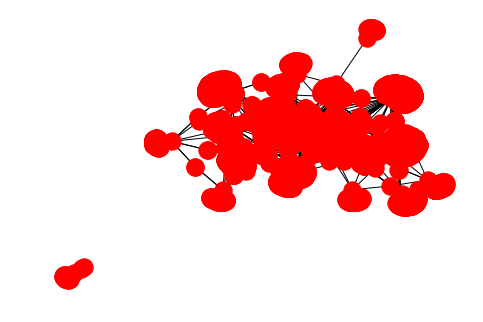

In [179]:
edges=g.edges
weights = [g[u][v]['usr_stars'] for u,v in edges]
nx.draw(g,with_labels=False,font_size=8)

lets develop a bi-weighted projected graph for the data above

In [180]:
#setup the bi-weighted graph lists
b=[]
u=[]

In [181]:
for row in a['name']:
    if row not in b:
        b.append(row)

In [182]:
for row in a['user_num']:
    if row not in u:
        u.append(row)

In [183]:
bnet=bip.weighted_projected_graph(g,b,ratio=False)
unet=bip.weighted_projected_graph(g,u,ratio=False)

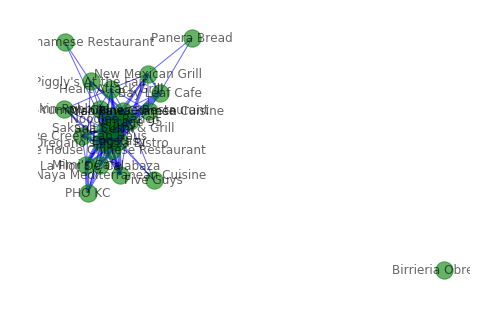

In [184]:
edges = bnet.edges()
weights = [bnet[u][v]['weight'] for u,v in edges]
nx.draw(bnet,with_labels=True,node_color='g',edge_color='b',width=weights,alpha=0.6)

In [185]:
bnet['Birrieria Obregon']

AtlasView({})

In [186]:
def trim_edges(g,threshold):
    p=nx.Graph()
    for f,to,edata in g.edges(data=True):
        if edata['weight']>threshold:
            p.add_edge(f,to,weight=edata['weight'])
    return p

In [187]:
bnet_trim=trim_edges(bnet,1)

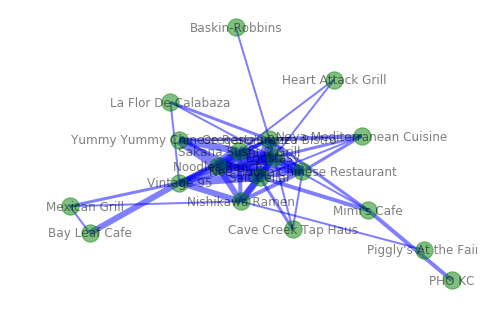

In [188]:
edges = bnet_trim.edges()
weights = [bnet_trim[u][v]['weight'] for u,v in edges]
nx.draw(bnet_trim,with_labels=True,node_color='g',edge_color='b',width=weights,alpha=0.5)

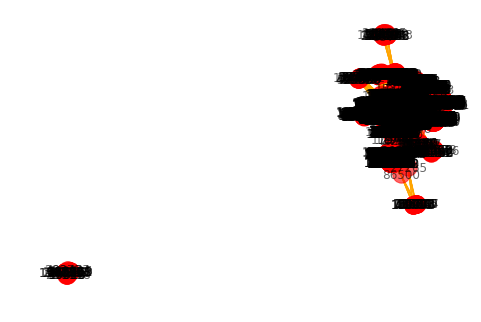

In [189]:
edges = unet.edges()
weights = [unet[u][v]['weight'] for u,v in edges]
nx.draw(unet,with_labels=True,node_color='r',edge_color='orange',width=weights,alpha=0.6)

In [190]:
unet_trim=trim_edges(unet,1)

In [216]:
##function from SNA for Startups (Maksim T. & Alex K.)
def sorted_map(map):
    ms = sorted(map.iteritems(), key=lambda (k,v): (-v,k))
    return ms

In [217]:
#calculate between-ness centrality
unet_bet_cent=sorted_map(nx.betweenness_centrality(unet))

In [228]:
unet_bet_cent[0:10]

[(116, 0.23391823631026312),
 (503, 0.052129266082754415),
 (933, 0.052129266082754415),
 (1070, 0.052129266082754415),
 (365, 0.041819300423951405),
 (949, 0.041819300423951405),
 (11734, 0.041819300423951405),
 (29197, 0.041819300423951405),
 (9, 0.0414069290702738),
 (2823, 0.0414069290702738)]

In [229]:
#calculate close-ness centrality
unet_close_cent=sorted_map(nx.closeness_centrality(unet))

In [230]:
unet_close_cent[0:10]

[(9, 0.7327652982184353),
 (2823, 0.7327652982184353),
 (4436, 0.7327652982184353),
 (4868, 0.7327652982184353),
 (14177, 0.7327652982184353),
 (27882, 0.7327652982184353),
 (116, 0.724904214559387),
 (365, 0.6657283603096411),
 (949, 0.6657283603096411),
 (11734, 0.6657283603096411)]

In [219]:
unet_deg_cent=nx.degree(unet)

In [240]:
sorted(unet_deg_cent,key=lambda (k,v):(-v,k))[0:10]

[(9, 601),
 (2823, 601),
 (4436, 601),
 (4868, 601),
 (14177, 601),
 (27882, 601),
 (116, 587),
 (365, 552),
 (949, 552),
 (11734, 552)]

(array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]),
 array([950.5, 950.6, 950.7, 950.8, 950.9, 951. , 951.1, 951.2, 951.3,
        951.4, 951.5]),
 <a list of 10 Patch objects>)

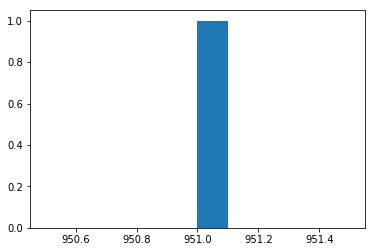

In [248]:
x=[len(c) for c in nx.connected_component_subgraphs(g)] 
py.hist(x)

In [246]:
print x

[951]


In [251]:
unet_trim=trim_edges(unet,1)

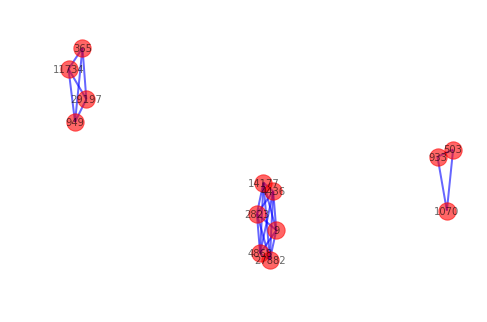

In [275]:
edges = unet_trim.edges()
weights = [unet_trim[u][v]['weight'] for u,v in edges]
nx.draw(unet_trim,with_labels=True,node_color='r',edge_color='b',width=weights,alpha=0.6,font_size=10)

In [299]:
a[a['user_num']==116]

,name,index_n,address,business_id,city,is_open,latitude,longitude,postal_code,bus_reviews,...,region_cat,cool,date,funny,review_id,usr_stars,useful,user_id,usr_reviews,user_num
33,Nee House Chinese Restaurant,21,"13843 N Tatum Blvd, Ste 15",44YFU284Z3KDEy25QyVoUw,Phoenix,1,33.613020,-111.977036,85032.0,269,...,Chinese,1,2010-06-13 19:53:39,0,72TJaNPJNFWOTNp94x60fw,5,2,kjeX2RXvW7RhBbD2QLd5jA,597,116
326,Vintage 95,37,95 W Boston,r8764MtYyt8JhxMvrfM_xQ,Chandler,0,33.302093,-111.842613,85225.0,320,...,American (New),8,2016-05-17 17:59:25,6,6CZEU3NGLFiM6Bo2371lVw,5,9,kjeX2RXvW7RhBbD2QLd5jA,597,116
2200,Nishikawa Ramen,94,1909 E Ray Rd,ecJri9ozyke4dOCWulZiRQ,Chandler,1,33.320006,-111.809675,85225.0,427,...,Japanese,12,2016-08-08 19:47:42,14,JQi7YXb8C7ZN26L1LFvmdA,4,16,kjeX2RXvW7RhBbD2QLd5jA,597,116
3084,Sakana Sushi & Grill,146,"6989 N Hayden Rd, Ste A12",QS3QxI7u5PRdtbGgI0-UsA,Scottsdale,1,33.538029,-111.905676,85250.0,347,...,Japanese,1,2012-01-06 03:50:36,3,3UmtrbQoOdJs6FnQgkD_xA,4,0,kjeX2RXvW7RhBbD2QLd5jA,597,116
3526,Noodles Ranch,153,"2765 N Scottsdale Rd, Ste 107",AMN3Sgns9tB2x-b3eWk0qQ,Scottsdale,1,33.479367,-111.924723,85257.0,457,...,Vietnamese,3,2010-05-22 23:08:09,1,OStmIPLNhu610b9ldxxVsg,4,4,kjeX2RXvW7RhBbD2QLd5jA,597,116


In [ ]:
plt.figure(figsize=(11, 11))
groups = set(node_groups) # get unique groups
node_groups_dict = nx.get_node_attributes(mid_subg[pos], 'group')
colors = [plt.cm.jet(x) for x in np.linspace(0, 1, len(groups))]
poss = nx.spring_layout(mid_subg[pos])

for i, groups in enumerate(groups):
    group_nodes = [node for node, value in node_groups_dict.items() if value == groups]
    nx.draw_networkx_nodes(mid_subg[pos], poss, nodelist=group_nodes, node_color=colors[i], label=groups,
                           with_labels=False, node_size=100, cmap=plt.cm.jet)
nx.draw_networkx_edges(mid_subg[pos], poss, alpha=0.2)

plt.legend()
plt.axis('off')
plt.show()

### References:
1. https://stackoverflow.com/questions/35588515/json-opening-yelp-data-challenges-data-set
2. https://stackoverflow.com/questions/43624065/yelp-data-file-type
3. https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.io.json.json_normalize.html#pandas.io.json.json_normalize
4. https://stackoverflow.com/questions/988228/convert-a-string-representation-of-a-dictionary-to-a-dictionary
5. https://github.com/kylegilde/NLP-and-Text-Mining-in-Python/tree/master/Classifying-Yelp-Reviews
6. https://github.com/nobieyi00/CUNY-SPS-DATA620/blob/master/FINAL_PROJECT/Data620_final_proj.ipynb
7. https://github.com/raghu74us/DATA-620/blob/master/FinalProject/DATA%20620%20Final%20Project.ipynb
8. https://github.com/jonathan1987/DATA620/blob/master/FinalProject/Final_project_notebook.ipynb
9. https://www.datacamp.com/community/tutorials/text-analytics-beginners-nltk